# Prepare matplotlib

In [88]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, NullFormatter

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

# Load data

In [89]:
# Functions for loading ewok data

ACC_KEY = "acc,none"
ERR_KEY = "acc_stderr,none"


def parse_ewok_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)

    subtask_acc = []
    subtask_err = []
    for subtask in data["group_subtasks"]["ewok_filtered"]:
        val = data["results"][subtask]
        subtask_acc.append(val[ACC_KEY])
        subtask_err.append(val[ERR_KEY])

    overall = data["results"]["ewok_filtered"]

    return {
        "overall": {"acc": overall[ACC_KEY], "err": overall[ERR_KEY]},
        "subtasks": {"acc": np.array(subtask_acc), "err": np.array(subtask_err)},
    }

# Load ewok data

In [120]:
# Load all ewok data -- by group

MAX_STEP = 20_000

ewok_scale_data = []
ewok_scale_err = []
ewok_acc = []
ewok_err = []
for scale in ("tiny", "small"):
    scale_data = []
    scale_acc = []
    scale_err = []

    for step in range(0, MAX_STEP + 1, 1_000):
        for exp in ("decoder", "relora"):
            path = Path(f"ewok_results/pico-{exp}-{scale}/step_{step}/ewok_results.json")
            data = parse_ewok_data(path)
            scale_data.append(data["subtasks"]["acc"])
            # ewok_scale_err.append(data["subtasks"]["err"])
            scale_acc.append(data["overall"]["acc"])
            scale_err.append(data["overall"]["err"])
    ewok_scale_data.append(scale_data)
    ewok_acc.append(scale_acc)
    ewok_err.append(scale_err)

In [91]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_27875/1275977461.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


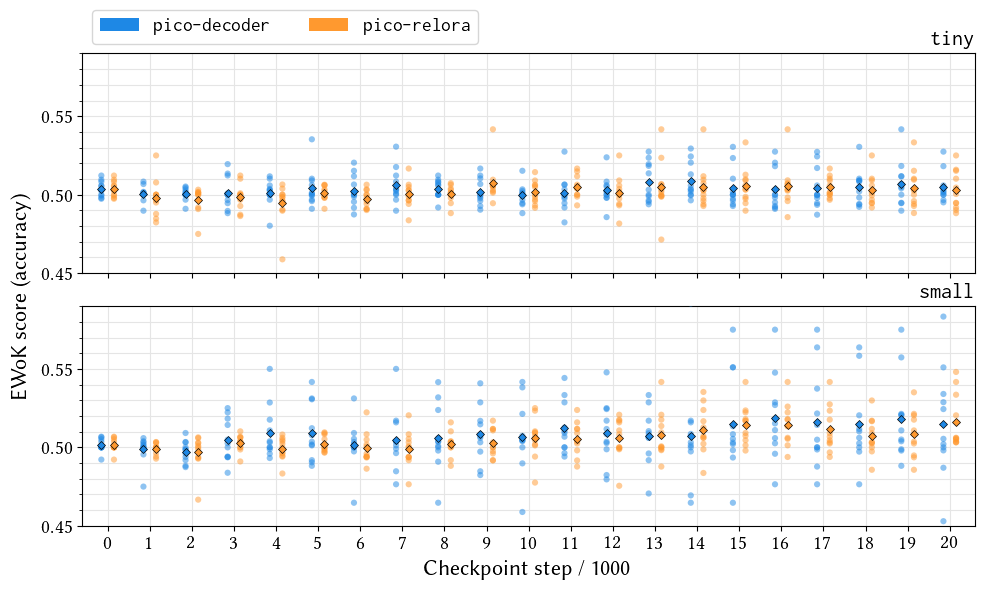

In [156]:
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(10, 6))

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]

positions = []

ticks = np.arange(0, (MAX_STEP // 1000) + 1, 1)

group_width = 0.9
offset = 0.15
positions = []

for i in ticks:
    positions.extend([i - offset, i + offset])

# Set colors for boxes
colors = ["#1E88E5", "#FF992F"]

titles = [r"\texttt{tiny}", r"\texttt{small}"]

for ax_idx, (ax, ewok_data) in enumerate(zip(axs, ewok_scale_data)):
    for idx, (ewok, pos) in enumerate(zip(ewok_data, positions)):
        jitter = np.zeros(len(ewok))

        color = colors[idx % 2]

        ax.scatter(
            pos + jitter,
            ewok,
            color=color,
            alpha=0.5,  # Transparency
            s=20,
            edgecolor="none",
            zorder=3,
        )

        # ax.errorbar(
        #     pos,
        #     ewok_acc[ax_idx][idx],
        #     yerr=ewok_err[ax_idx][idx],
        #     color=color,
        #     ecolor="black",
        #     capsize=2,
        #     elinewidth=1,
        #     fmt="D",
        #     markersize=3,
        #     zorder=3,
        #     markeredgecolor="black",
        #     markeredgewidth=0.5,
        # )

        # print(ewok_acc[ax_idx].shape)
        ax.plot(
            pos,
            ewok_acc[ax_idx][idx],
            marker="D",
            markersize=4,
            markerfacecolor=color,
            markeredgecolor="black",
            markeredgewidth=0.5,
            zorder=6,
        )

    ax.set_xticks(ticks)

    ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

    if ax_idx == 0:
        ax.tick_params(axis="x", which="both", labelbottom=False)
    else:
        ax.set_xlabel("Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE)

    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(0.45, 0.59)
    ax.set_xlim(-0.6, 20.6)

    ax.grid(which="both", axis="both", color="#E5E5E5")

    ax.set_title(titles[ax_idx], loc="right", fontsize=AXIS_LABEL_SIZE)

    if ax_idx == 0:
        legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]
        # Add the legend
        ax.legend(
            handles=legend_elements,
            loc="lower left",
            bbox_to_anchor=(0, 1),
            # borderaxespad=0.2,
            fontsize=TICK_LABEL_SIZE,
            ncols=2,
        )


fig.supylabel("EWoK score (accuracy)", size=AXIS_LABEL_SIZE)

# fig.supxlabel(r"BLiMP phenomenon", size=AXIS_LABEL_SIZE, y=0.06)

fig.tight_layout()
fig.subplots_adjust(hspace=0.15)
fig.savefig("../graphs/ewok_strip.pdf")
fig.show()

# Check whether results are random (p value statistical testing)

In [203]:
subtask_counts = {
    "agent-properties": 2240,
    "material-dynamics": 1560,
    "material-properties": 248,
    "physical-dynamics": 150,
    "physical-interactions": 560,
    "physical-relations": 830,
    "quantitative-properties": 380,
    "social-interactions": 350,
    "social-properties": 370,
    "social-relations": 1570,
    "spatial-relations": 490,
}

TOTAL_SUBTASKS = sum(subtask_counts.values())

In [204]:
full_res = {}
for scale in ("tiny", "small"):
    for ty in ("relora", "decoder"):
        for step in range(0, 20_001, 1_000):
            res_path = Path(f"ewok_results/pico-{ty}-{scale}/step_{step}/ewok_results.json")
            with res_path.open() as f:
                data = json.load(f)
            step_d = {}
            for subtask, count in subtask_counts.items():
                acc = data["results"][f"ewok_{subtask}_filtered"]["acc,none"]
                st_c = round(acc * count)
                step_d[subtask] = {"count": st_c, "acc": acc}

            full_res[f"{ty}-{scale}-{step}"] = step_d

In [217]:
p = 0.5
sig = 0.05
VERB = False
ckps_sig = 0
sig_res = []
for res, subtasks in full_res.items():
    if VERB:
        print(res)
    total_correct = 0
    num_sig = 0
    accs = []
    # subtasks
    for st, stv in subtasks.items():
        k = stv["count"]
        accs.append(stv["acc"])
        total_correct += k
        n = subtask_counts[st]
        p_val = sps.binom.cdf(k, n, p)
        if k > n * p:
            p_val = 1 - p_val

        p_val *= 2

        if p_val <= sig:
            num_sig += 1

        if VERB:
            print(f"{st} = acc: {k / n:.3f}, p: {p_val:.3f}")
    # whole task test

    p_val = sps.binom.cdf(total_correct, TOTAL_SUBTASKS, p)
    if total_correct > n * p:
        p_val = 1 - p_val

    p_val *= 2

    score = np.mean(accs)

    if p_val <= sig:
        ckps_sig += 1
        sig_res.append((res, score, num_sig))

    if VERB:
        print(f"whole task =  acc: {score:.3f}, p: {p_val:.3f}. sig tasks = {num_sig}")
        print()

print(f"TOTAL SIG: {ckps_sig}")
print(sig_res)

TOTAL SIG: 4
[('relora-small-16000', np.float64(0.5144832906780716), 1), ('relora-small-20000', np.float64(0.5159989473920152), 1), ('decoder-small-16000', np.float64(0.5185039398843266), 0), ('decoder-small-19000', np.float64(0.5181336712355828), 1)]


# With multiple p value correction

In [221]:
p = 0.5
sig = 0.05
ckps_sig = 0
p_vals = []
results_info = []
for res, subtasks in full_res.items():
    total_correct = 0
    num_sig = 0
    accs = []
    # subtasks
    for stv in subtasks.values():
        accs.append(stv["acc"])
        total_correct += stv["count"]

    # whole task test

    p_val = sps.binom.cdf(total_correct, TOTAL_SUBTASKS, p)
    if total_correct > n * p:
        p_val = 1 - p_val
    p_val *= 2

    if p_val > 1:
        p_val = 1

    p_vals.append(p_val)

    score = np.mean(accs)

    results_info.append((res, score))


adj_p_vals = sps.false_discovery_control(p_vals)
for adj_p, info in zip(adj_p_vals, results_info):
    # print(info, adj_p)
    if adj_p <= sig:
        print(f"{info[0]} is significant!")